## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
import tensorflow as tf
import keras.backend as K

def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_wght, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_focal(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        epsilon = 1e-8
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        return ce * ce_wght + tf.reduce_mean(reduced_fl) * (1.0 - ce_wght)
    return ce_focal
    
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [12]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
        

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128) 

Epoch 14/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.6942 - acc: 0.6515 - val_loss: 2.8857 - val_acc: 0.4778
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.6247 - acc: 0.6610 - val_loss: 2.9331 - val_acc: 0.4797
Epoch 16/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.5524 - acc: 0.6760 - val_loss: 2.8201 - val_acc: 0.4787
Epoch 17/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4683 - acc: 0.6887 - val_loss: 2.8823 - val_acc: 0.4853
Epoch 18/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4103 - acc: 0.6964 - val_loss: 2.8788 - val_acc: 0.4858: 0s - loss: 1.4154
Epoch 19/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.3350 - acc: 0.7107 - val_loss: 2.9212 - val_acc: 0.4777
Epoch 20/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2606 - acc: 0.7239 - val_loss: 2.9655 - val_acc: 0.4837
Epoch 21/25
500

Epoch 2/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.6105 - acc: 0.3931 - val_loss: 1.7117 - val_acc: 0.3838
Epoch 3/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.4552 - acc: 0.4362 - val_loss: 1.5422 - val_acc: 0.4084
Epoch 4/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.3646 - acc: 0.4626 - val_loss: 1.4833 - val_acc: 0.4230
Epoch 5/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2984 - acc: 0.4829 - val_loss: 1.4492 - val_acc: 0.4309
Epoch 6/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2432 - acc: 0.4997 - val_loss: 1.4046 - val_acc: 0.4491
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.1974 - acc: 0.5144 - val_loss: 1.3841 - val_acc: 0.4481
Epoch 8/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.1564 - acc: 0.5284 - val_loss: 1.3604 - val_acc: 0.4576
Epoch 9/25
50000/50000 [=================

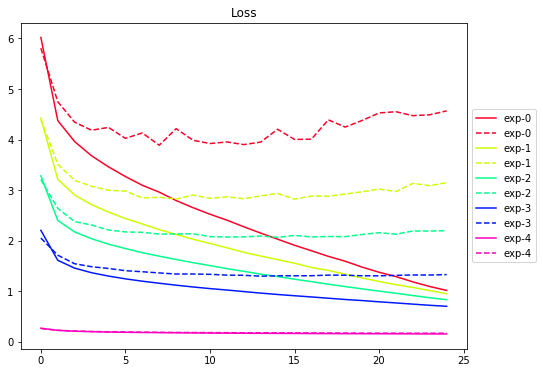

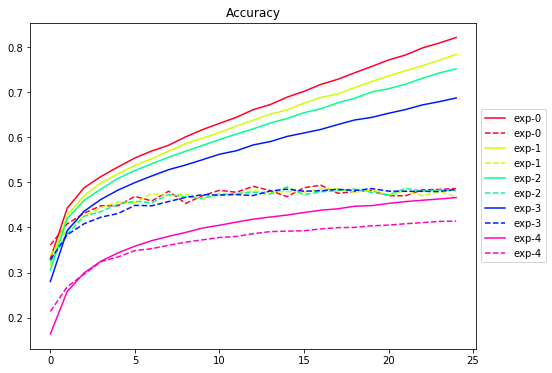

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()